🔍 Scanning dataset...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
✅ hand1_a_bot_seg_1_cropped.jpeg — True: A, Predicted: A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
✅ hand1_a_bot_seg_1_cropped.jpeg — True: A, Predicted: A
❌ No hand detected in: hand1_a_bot_seg_2_cropped.jpeg
❌ No hand detected in: hand1_a_bot_seg_3_cropped.jpeg
❌ No hand detected in: hand1_a_bot_seg_4_cropped.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
✅ hand1_a_bot_seg_5_cropped.jpeg — True: A, Predicted: A
❌ No hand detected in: hand1_a_dif_seg_1_cropped.jpeg
❌ No hand detected in: hand1_a_dif_seg_2_cropped.jpeg
❌ No hand detected in: hand1_a_dif_seg_3_cropped.jpeg
❌ No hand detected in: hand1_a_dif_seg_4_cropped.jpeg
❌ No hand detected in: hand1_a_dif_seg_5_cropped.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
✅ hand1_a_left_seg_1_cropped.jpeg — True: A, Predicted: A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
✅ hand1_a_left_seg_2_cropped.jpeg — True: A, Predicted: A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
✅ hand1_a_left_seg_3_cropped.j

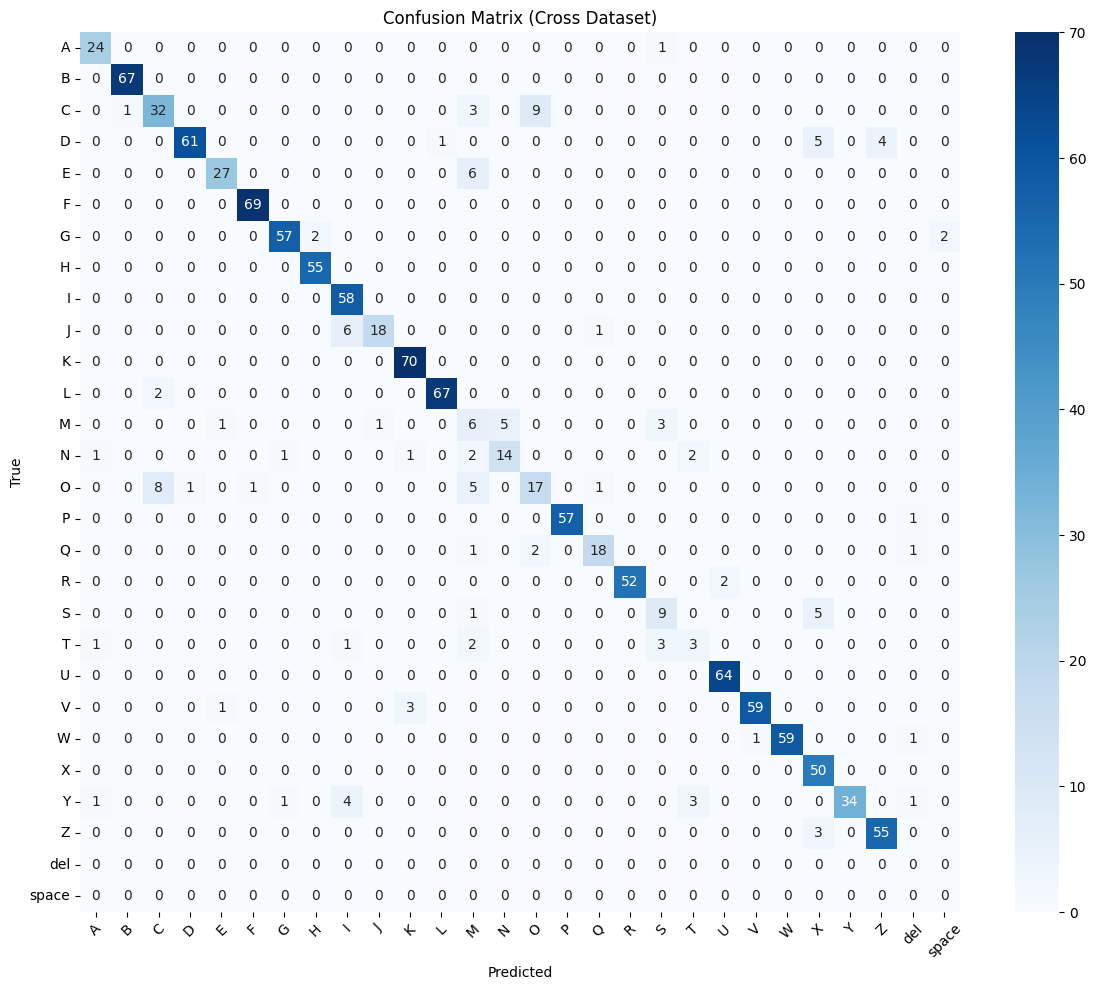


📋 Classification Report:
              precision    recall  f1-score   support

           A       0.89      0.96      0.92        25
           B       0.99      1.00      0.99        67
           C       0.76      0.71      0.74        45
           D       0.98      0.86      0.92        71
           E       0.93      0.82      0.87        33
           F       0.99      1.00      0.99        69
           G       0.97      0.93      0.95        61
           H       0.96      1.00      0.98        55
           I       0.84      1.00      0.91        58
           J       0.95      0.72      0.82        25
           K       0.95      1.00      0.97        70
           L       0.99      0.97      0.98        69
           M       0.23      0.38      0.29        16
           N       0.74      0.67      0.70        21
           O       0.61      0.52      0.56        33
           P       1.00      0.98      0.99        58
           Q       0.90      0.82      0.86        22
 

C:\Users\shree\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shree\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shree\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [3]:
import os
import cv2
import numpy as np
import pickle
import re
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import mediapipe as mp

# --- Config ---
DATA_DIR = 'ASL_Alphabet_Dataset\\asl_dataset'  # change this
VALID_LABELS = set("ABCDEFGHIJKLMNOPQRSTUVWXYZ")  # adapt if lowercase or includes 'space', 'del'
MIN_CONF = 0.3 # mediapipe detection threshold

# Load model & label encoder
model = load_model('asl_cnn_2D_model.h5')
with open('label_encoder.pickle', 'rb') as f:
    label_encoder = pickle.load(f)
CLASS_NAMES = label_encoder.classes_

# Mediapipe setup
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=MIN_CONF)

# Storage
true_labels = []
predicted_labels = []

# Helper to extract label from filename
def extract_label_from_filename(fname):
    match = re.search(r'hand\d*_([a-zA-Z])_', fname)
    return match.group(1).upper() if match else None

# Loop through all folders/files
print("🔍 Scanning dataset...")
for root, _, files in os.walk(DATA_DIR):
    for file in files:
        if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        true_label = extract_label_from_filename(file)
        if not true_label or true_label not in CLASS_NAMES:
            continue  # skip unknown or unsupported labels

        file_path = os.path.join(root, file)
        image = cv2.imread(file_path)
        if image is None:
            continue

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = hands.process(image_rgb)

        if not results.multi_hand_landmarks:
            print(f"❌ No hand detected in: {file}")
            continue

        # Extract 42 features
        for hand_landmarks in results.multi_hand_landmarks:
            landmark_data = []
            for point in hand_landmarks.landmark:
                landmark_data.append(point.x)
                landmark_data.append(point.y)

            if len(landmark_data) < 42:
                continue

            input_data = np.array(landmark_data[:42]).reshape(1, -1)
            prediction = model.predict(input_data)
            predicted_index = np.argmax(prediction, axis=1)[0]
            predicted_label = CLASS_NAMES[predicted_index]

            true_labels.append(true_label)
            predicted_labels.append(predicted_label)

            print(f"✅ {file} — True: {true_label}, Predicted: {predicted_label}")

# Results
if true_labels:
    acc = accuracy_score(true_labels, predicted_labels)
    print(f"\n✅ Cross-Dataset Accuracy: {acc:.4f}")

    cm = confusion_matrix(true_labels, predicted_labels, labels=CLASS_NAMES)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title("Confusion Matrix (Cross Dataset)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print("\n📋 Classification Report:")
    print(classification_report(true_labels, predicted_labels, labels=CLASS_NAMES))
else:
    print("❌ No valid hand detections made from the cross-check dataset.")
